In [1]:
%load_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%aimport SweetSpotPrediction
import SweetSpotPrediction as ssp

# 01 Data Preperation
Here we can convert the raw data into our features and labels.

*Paths*
* Classification: Simple datatable for each (X,Y) Pos
<table>
    <thead><tr><td>X pos</td><td>Y pos</td><td>value_map_1</td><td>value_map_2</td><td>value_map_3</td><td>A_well_was_drilled_at_this_pos</td></tr></thead>
    <tr><td>0</td><td>0</td><td>5.2</td><td>1.2</td><td>1.2</td><td>False</td></tr>
    <tr><td>0</td><td>1</td><td>6.3</td><td>6.3</td><td>6.3</td><td>True</td></tr>
    </table>
* Regression: Simple datatable for each (X,Y) Pos. Distance factor (0.0-1.0) should probably be a quadratic factor?
<table>
    <thead><tr><td>X pos</td><td>Y pos</td><td>value_map_1</td><td>value_map_2</td><td>value_map_3</td><td>Distance_factor_from_actual_well</td></tr></thead>
    <tr><td>0</td><td>0</td><td>5.2</td><td>1.2</td><td>1.2</td><td>0.62</td></tr>
    <tr><td>0</td><td>1</td><td>6.3</td><td>6.3</td><td>6.3</td><td>1.0</td></tr>
    </table>
* Deep Learning (**Out of scope**): Combine the 2D maps into a single feature space and as a lable a 2D mask with actual production well location (perfect for convolutional neural networks)

# Read Maps, including Well Probability

In [2]:
# File paths with corresponding map names
files_names = {'Data\\thickness\\thickness': 'Thickness'
         , 'Data\\avgntg\\avgntgasc': 'AvgNTG'
         , 'Data\\avgperm\\avgpermasc': 'AvgPerm'
         , 'Data\\avgporo\\avgporoasc': 'AvgPoro'
         , 'Data\\netperm\\netpermasc': 'NetPerm'
         , 'Data\\distwellweight.txt': 'WellProbability'
              }

# Read map files
dfs = []
spacing = 50 # map grid cell dimension
for key in files_names:
    df = pd.read_csv(key, delimiter=' ', comment='#', names=['XPos', 'YPos', files_names[key], 'c1', 'c2'])
    df.drop(columns=['c1', 'c2'], inplace=True)
    df_reg = ssp.make_regular(df, files_names[key], spacing)
    df_reg.set_index(['XPos','YPos'], inplace=True)
    dfs = dfs + [df_reg]

# Merge dataframes
df = pd.concat(dfs, axis='columns', join='inner').reset_index()

# Add Well locations (Classification)

In [3]:
# Get well locations
file = 'Data\\welltops.txt'

wells = pd.read_csv(file, delimiter='\t')

In [4]:
# This is a fudge, for now

df['WellPresent'] = df.WellProbability > 0.75

In [5]:
df.head()

,XPos,YPos,Thickness,AvgNTG,AvgPerm,AvgPoro,NetPerm,WellProbability,WellPresent
0,452000.0,6780600.0,-19.843674,NaN,NaN,NaN,NaN,NaN,False
1,452000.0,6780650.0,-17.164212,NaN,NaN,NaN,NaN,NaN,False
2,452000.0,6780700.0,-14.827628,NaN,NaN,NaN,NaN,NaN,False
3,452000.0,6780750.0,-14.540321,NaN,NaN,NaN,NaN,NaN,False
4,452000.0,6780800.0,-15.951475,NaN,NaN,NaN,NaN,NaN,False


In [6]:
features = [
    #'XPos', # propbably dont want these as features
    #'YPos', # propbably dont want these as features
    'Thickness',
    'AvgNTG',
    'AvgPerm',
    'AvgPoro',
    'NetPerm',

]

label_clf = 'WellPresent' 
label_reg = 'WellProbability'

# Data cleaning

In [7]:
# Functions to drop values less than zero or greater than one

def drop_neg(x):
    if x < 0:
        return np.nan
    else:
        return x

def drop_gt1(x):
    if x > 1:
        return np.nan
    else:
        return x

In [8]:
# Clean dataframe according to specified columns to remove negatives or greater than one

df_clean = df.copy()

cols_remove_negs = set(df_clean.columns) - {'XPos', 'YPos'}
cols_remove_gt1 = {'AvgNTG', 'WellProbability'}

for col in df_clean.columns:
    if col in cols_remove_negs:
        df_clean[col] = df_clean[col].apply(drop_neg)
    if col in cols_remove_gt1:
        df_clean[col] = df_clean[col].apply(drop_gt1)

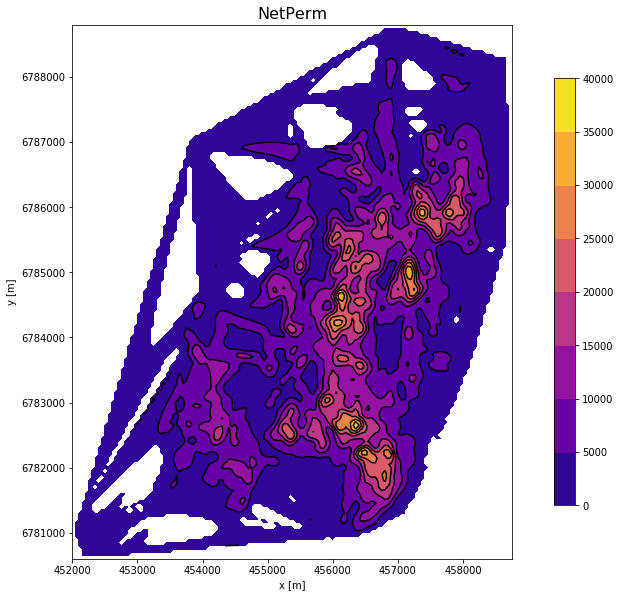

In [9]:
# QC plot cleaned maps

plot = 'NetPerm'
ssp.plot_map(df_clean, plot)

# Correlations

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


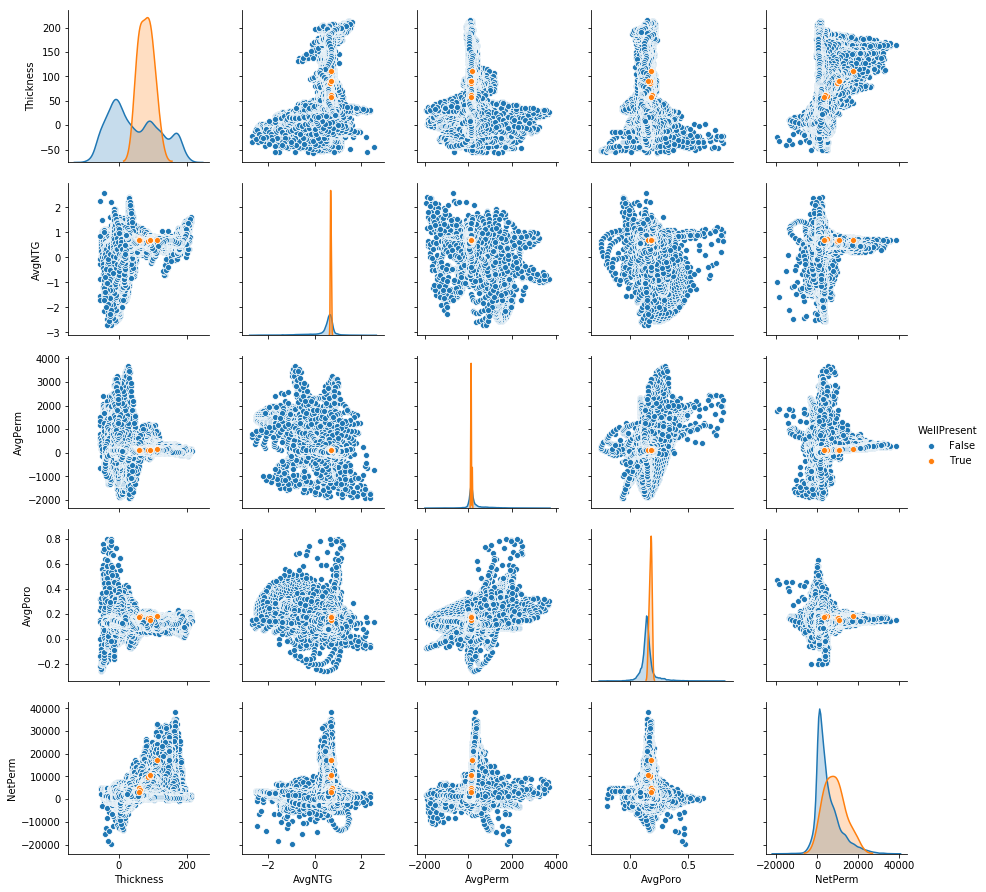

In [10]:
sns.pairplot(df, vars=features, hue='WellPresent' )

# Feature Engineering

# Save the data

In [11]:
df_cls = df_clean.drop(columns='WellProbability')
df_rgs = df_clean.drop(columns='WellPresent')

df_cls.to_csv('ClassificationData.csv')
df_rgs.to_csv('RegressionData.csv')

# Copy paste features and Labels

# TODO
* Discuss Train/Validation/Test split (arbitrary random or specific say reserving a few wells for each set)??

# <a href="02 Base Model.ipynb">Next</a> Notebook